shape= (2000, 3)


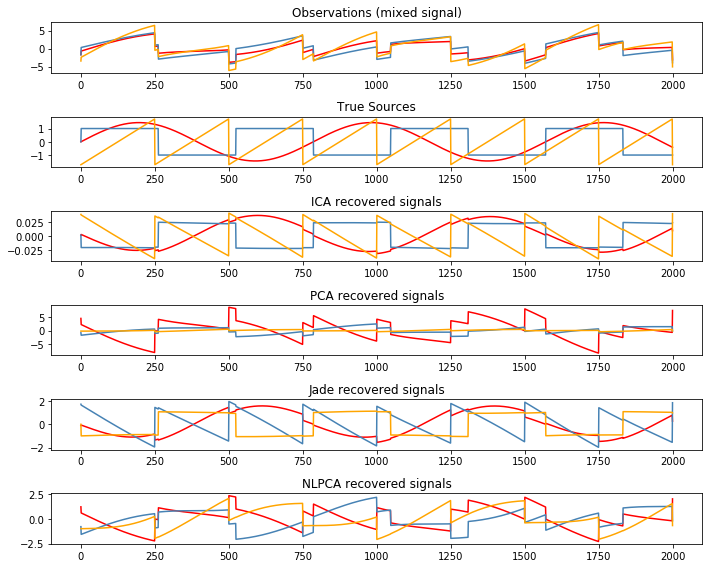

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import mdp
from sklearn.decomposition import FastICA, PCA
from scipy.cluster.vq import whiten


def g(y):
    #return np.multiply(np.power(y,2),np.sign(y))
    return np.tanh(y)
def NPCA_RLS(mixtures, runs = 1):
    P = np.identity(mixtures.shape[0])
    W = np.identity(mixtures.shape[0])
    dW =np.zeros(W.shape)
    y = np.zeros(mixtures.shape)
    beta = 0.9
    pca = PCA(whiten=True)
    whitenedMixtures = pca.fit_transform(mixtures)
    print ("shape=", whitenedMixtures.shape)
    #whitenedMixtures = whiten(mixtures)
    #whitenedMixtures = mixtures
    for j in np.arange(runs):
        for i in np.arange(whitenedMixtures.shape[1]):
            y[:,i] = np.dot(W, whitenedMixtures[:,i])
            z = g(y[:,i])
            h = np.dot(P,z)
            m = h/(beta + np.dot(z.T, h))

            Triangle = P - np.outer(m, h.T)
            lowerIndices = np.tril_indices(whitenedMixtures.shape[0])
            Triangle[lowerIndices] = Triangle.T[lowerIndices]

            P = (1/beta) * Triangle
            e =  whitenedMixtures[:,i] - np.dot(W.T,z)
            
            dW = np.outer(m, e.T)
            
            W = W + dW
            if (np.isnan(W).any() == True):
                print('Lost convergence at iterator %d'%i)
                break
            elif np.all(np.absolute(W) < 1e-6):
                print('Found convergence at iterator %d on run %d'%(i,j))
                break
    return y, W



# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
#S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

# #############################################################################
# Plot results

bandeira=NPCA_RLS(X)



node = mdp.nodes.JADENode()
node.train(X)
proj_data = node.execute(X)
#proj_data = proj_data.T


plt.figure(figsize=(10,8))

models = [X, S, S_, H, proj_data,bandeira[0]]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals',
         'Jade recovered signals', 
         'NLPCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(len(names), 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.tight_layout()
plt.show()